## Step 4: Cross-text Network Comparison

### Conceptual Motivation

While previous steps examined lexical frequency and local co-occurrence patterns,
this step shifts the analysis toward **structural comparison**.

The goal is to understand how cultural meanings are organized as *networks*:
- which concepts act as hubs,
- which semantic domains are tightly integrated,
- and which remain fragmented or isolated.

Community detection is introduced not as an exploratory novelty,
but as a **validation mechanism**:
it tests whether previously identified cultural patterns
emerge organically from the network structure
without predefined semantic categories.

## Data Preparation

In [26]:
import networkx as nx
from itertools import combinations
from collections import Counter
from pathlib import Path

In [27]:
DATA_DIR = Path("../data/processed")

files = {
    "eneida": DATA_DIR / "eneida_clean.txt",
    "odyssey": DATA_DIR / "odyssey_clean.txt",
    "ulysses": DATA_DIR / "ulysses_clean.txt"
}

tokens_by_text = {}
for name, path in files.items():
    if path.exists():
        with open(path, "r", encoding="utf-8") as f:
            tokens_by_text[name] = f.read().split()
        print(f"Loaded {len(tokens_by_text[name])} tokens for {name}")
    else:
        print(f"File not found: {path}")

Loaded 32126 tokens for eneida
Loaded 127476 tokens for odyssey
Loaded 264889 tokens for ulysses


In [28]:
STOP_WORDS = {
    'і', 'не', 'на', 'в', 'що', 'з', 'як', 'а', 'та', 'по', 'въ', 'и', 'до', 'у', 'же',
    'якъ', 'зъ', 'щобъ', 'щоб', 'бъ', 'чи', 'це', 'то', 'все', 'так', 'при', 'ад', 
    'від', 'од', 'от', 'ті', 'собі', 'мене', 'його', 'йому', 'іому', 'те', 'ми', 'ви', 'він',
    'хто', 'всіх', 'тутъ', 'такъ', 'тут', 'всѣ', 'за', 'вже', 'який', 'собѣ', 
    'був', 'була', 'було', 'були', 'дуже', 'свої', 'свою', 'тепер', 'тільки', 'хоч', 
    'мов', 'хоть', 'съ', 'їх', 'тебе', 'ти', 'із', 'бо', 'но', 'да', 'без', 'для',
    'де', 'ты', 'коли', 'уже', 'ни', 'изъ', 'всі', 'ихъ', 'бувъ', 'іого', 'мовъ', 'винъ',
    'тамъ', 'сам', 'там', 'къ', 'ажъ', 'себе', 'буде', 'отъ', 'яка', 'яке', 'тїї', 'передь',
    'заразъ', 'зараз', 'трохи', 'ввесь', 'мати', 'може', 'був', 'стала', 'стали', 'нехай',
    'перед', 'через', 'над', 'під', 'біля', 'собі', 'собі', 'мене', 'нас', 'вам', 'вас', 'вся',
    'се', 'цей', 'ним', 'тобѣ', 'имъ', 'зо', 'єсть', 'всѣмъ', 'або', 'сей', 'їм', 'самъ', 'тилько',
    'нам', 'чого', 'безъ', 'собою', 'вона', 'бы', 'ось', 'би', 'треба', 'про', 'всім', 'всякий', 
    'тоді', 'той', 'всю', 'ну', 'всѣхъ', 'свій', 'її', 'них', 'ѣй', 'аж', 'послѣ', 'мы', 'минѣ',
    'лишъ', 'твій', 'кого', 'наш', 'їй', 'вы', 'мій', 'моя', 'таки', 'яки', 'кому', 'жъ', 'які',
    'неї', 'неи', 'нимъ', 'насъ', 'вони', 'між', 'вамъ', 'намъ', 'нею', 'нихъ', 'своихъ', 
    'чѣмъ', 'ще', 'ними', 'того', 'также', 'сама', 'якій', 'сами', 'поки', 'куди', 'лиш', 
    'цим', 'ище', 'своимъ', 'васъ', 'весь', 'нашъ', 'есть', 'ця', 'ваш', 'своїм', 'тож', 
    'предъ', 'сихъ', 'тѣ', 'the', 'and', 'to', 'of', 'a', 'in', 'he', 'his', 'for', 'that', 'with', 'was', 'as', 
    'it', 'is', 'you', 'him', 'they', 'on', 'me', 'had', 'all', 'my', 'but', 'have', 
    'from', 'at', 'by', 'she', 'her', 'said', 'were', 'be', 'an', 'so', 'their', 'which',
    'not', 'them', 'will', 'this', 'when', 'your', 'who', 'are', 'then', 'or', 'out', 
    'what', 'up', 'like', 'there', 'one', 'would', 'could', 'been', 'about', 'can',
    'if', 'no', 'mr', 'into', 'some', 'more', 'did', 'now', 'its', 'through', 'only',
    'we', 'do', 'has', 'us', 'over', 'too', 'upon', 'may', 'shall', 'should', 'must',
    'went', 'come', 'go', 'came', 'down', 'see', 'after', 'two', 'time', 'man', 'men',
    'own', 'away', 'back', 'well', 'long', 'made', 'take', 'way', 'know', 'than', 'first',
    'any', 'tell', 'here', 'says', 'off', 'yes', 'other', 'those', 'our', 'let', 'much', 
    'am', 'where', 'took', 'while'
}

In [29]:
def build_cooccurrence_network(tokens, window_size=5, min_freq=5):
    clean_tokens = [
        t.lower() for t in tokens 
        if t.lower() not in STOP_WORDS and len(t) > 2
    ]
    
    freq = Counter(clean_tokens)
    
    top_tokens = [t for t in clean_tokens if freq[t] >= min_freq]

    G = nx.Graph()
    
    for i in range(len(top_tokens) - window_size):
        window = top_tokens[i : i + window_size]
        for w1, w2 in combinations(window, 2):
            if w1 == w2:
                continue
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)
    
    return G

The window size of 5 tokens was chosen as a compromise:
large enough to capture local semantic context,
but small enough to avoid narrative-scale associations.
Exploratory tests with larger windows (10–15)
did not alter the global structural patterns.

In [30]:
networks = {
    name: build_cooccurrence_network(tokens)
    for name, tokens in tokens_by_text.items()
}

## Global Network Metrics

In [31]:
import pandas as pd

def network_metrics(G):
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "clustering": nx.average_clustering(G)
    }

metrics_df = pd.DataFrame.from_dict(
    {name: network_metrics(G) for name, G in networks.items()},
    orient='index'
)

metrics_df

,nodes,edges,density,avg_degree,clustering
eneida,529,14097,0.100941,53.296786,0.275471
odyssey,1951,115537,0.060738,118.438749,0.351569
ulysses,5149,314781,0.023751,122.268790,0.235967


The gradual decrease in network density from Eneida to Ulysses quantitatively reflects the transition from a culturally shared semantic world to an individualized associative one

## Community Detection

Communities are detected using the Louvain algorithm,
which identifies densely connected groups of nodes.

These communities are interpreted as **emergent semantic clusters**:
they are not imposed by predefined categories,
but arise from repeated patterns of co-occurrence in the text.

This allows us to compare:
- integrated vs fragmented cultural worlds,
- dominant semantic hubs,
- and the internal logic of each narrative system.

In [32]:
import sys
import subprocess

# 1. Примусове встановлення через поточний інтерпретатор
subprocess.check_call([sys.executable, "-m", "pip", "install", "python-louvain"])

# 2. Оновлення шляхів пошуку
import site
from importlib import reload
reload(site)

# 3. Спроба імпорту через повну назву
try:
    import community as community_louvain
    print("УСПІХ: Модуль 'community' завантажено!")
except ImportError:
    try:
        import community_louvain
        print("УСПІХ: Модуль 'community_louvain' завантажено!")
    except ImportError:
        print("Жоден варіант не спрацював.")

УСПІХ: Модуль 'community' завантажено!


In [33]:
def detect_communities(G):
    partition = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, partition, 'community')
    return partition

partitions = {
    name: detect_communities(G)
    for name, G in networks.items()
}

## Community-Level Analysis

In [34]:
def community_sizes(partition):
    return Counter(partition.values())

community_summary = {
    name: community_sizes(part)
    for name, part in partitions.items()
}

In [35]:
def top_words_per_community(G, n=10):
    communities = {}
    for node, data in G.nodes(data=True):
        c = data['community']
        communities.setdefault(c, []).append(node)
    return {
        c: words[:n]
        for c, words in communities.items()
    }

## Network Visualization

In [36]:
import matplotlib.pyplot as plt

def plot_community_graph(G, title):
    Gcc = max(nx.connected_components(G), key=len)
    H = G.subgraph(Gcc)

    pos = nx.spring_layout(H, seed=42)
    communities = nx.get_node_attributes(H, 'community')
    
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(
        H, pos,
        node_size=30,
        cmap=plt.cm.tab20,
        node_color=list(communities.values())
    )
    nx.draw_networkx_edges(H, pos, alpha=0.1)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [37]:
print("Community Sizes Summary:")
for name, summary in community_summary.items():
    print(f"{name.capitalize()}: {dict(summary)}")

for name, G in networks.items():
    print(f"\n--- TOP WORDS PER COMMUNITY: {name.upper()} ---")
    top_words = top_words_per_community(G, n=10)
    for community_id, words in top_words.items():
        # Виводимо тільки громади, де більше 5 слів, щоб не спамити дрібницями
        if len(words) >= 5:
            print(f"Cluster {community_id}: {', '.join(words)}")

Community Sizes Summary:
Eneida: {2: 24, 1: 199, 4: 189, 3: 114, 0: 3}
Odyssey: {8: 350, 6: 249, 2: 375, 3: 545, 4: 199, 7: 120, 0: 11, 1: 19, 5: 83}
Ulysses: {0: 918, 1: 1121, 2: 1208, 3: 1020, 5: 653, 6: 185, 4: 44}

--- TOP WORDS PER COMMUNITY: ENEIDA ---
Cluster 2: часть, лихо, трою, тягу, сонце, тобою, жила, дать, чорту, земля
Cluster 1: еней, куды, давъ, троянцивъ, швидко, човны, море, очи, страхъ, давно
Cluster 4: зла, юнона, енея, злую, пропало, руку, таку, рукою, берега, така
Cluster 3: дочка, гарну, буть, бере, силу, зевесу, ралець, слова, енею, хочу

--- TOP WORDS PER COMMUNITY: ODYSSEY ---
Cluster 8: gods, visit, muse, hero, famous, troy, many, cities, whose, moreover
Cluster 6: telemachus, suitors, town, ulysses, himself, spoke, knew, told, listen, minerva
Cluster 2: travelled, suffered, trying, save, life, bring, safely, home, might, perished
Cluster 3: far, wide, sacked, sea, sheer, got, calypso, large, cave, end
Cluster 4: eating, cattle, sungod, sheep, oxen, house, ser

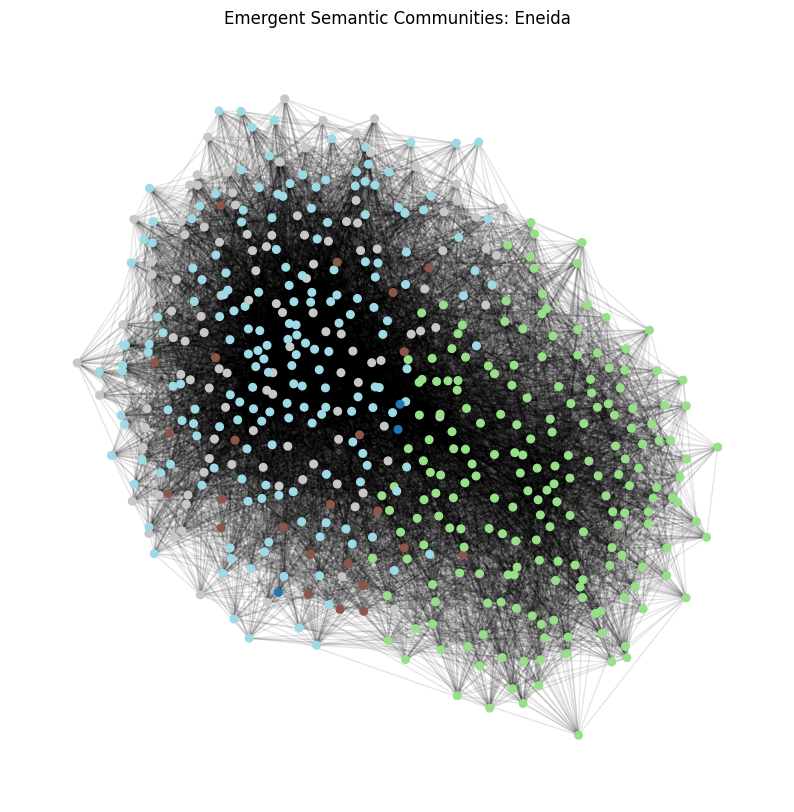

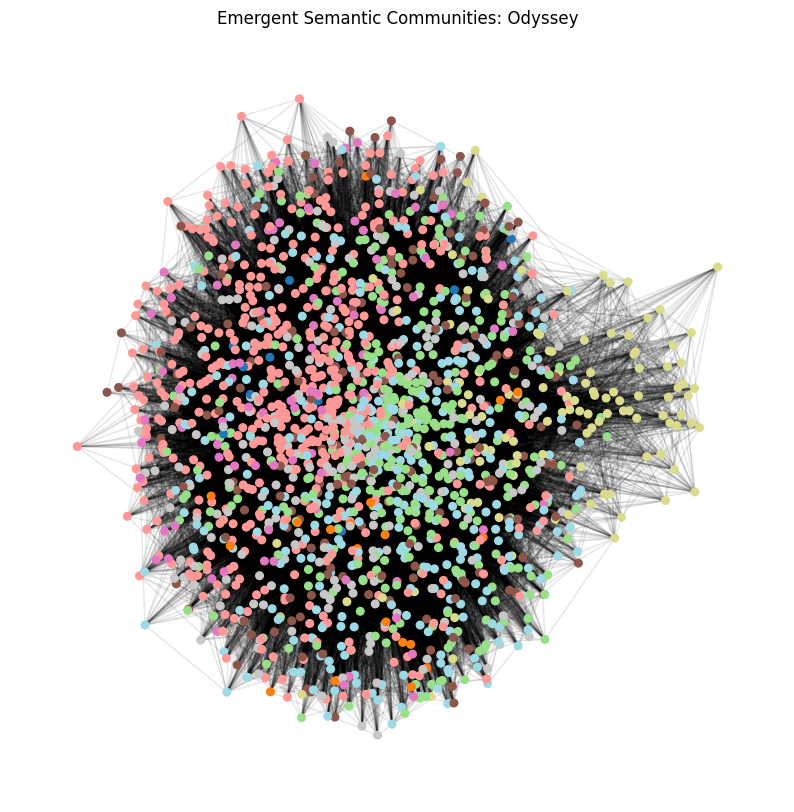

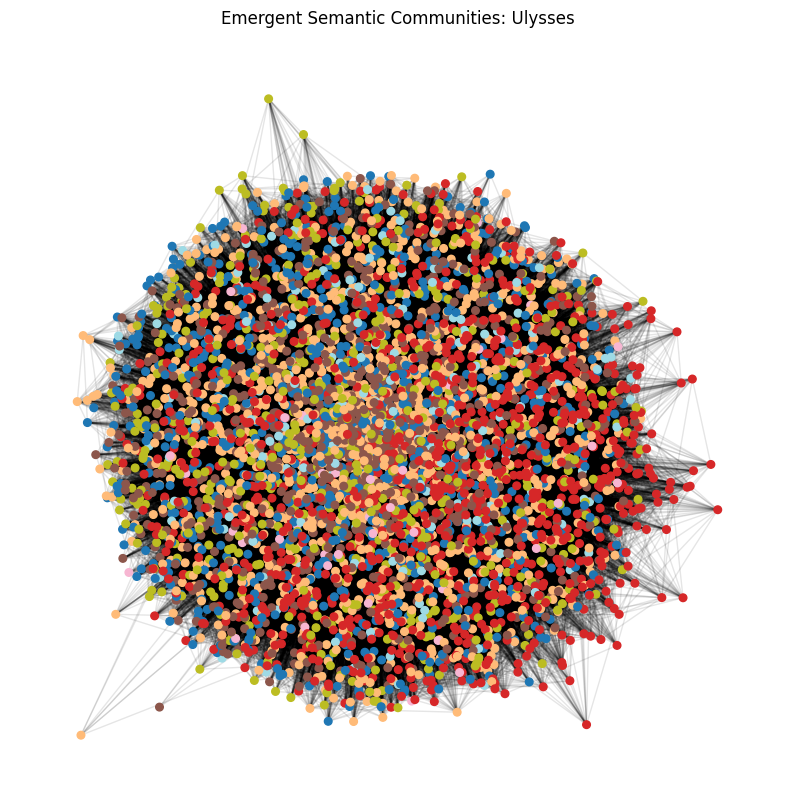

In [38]:
for name, G in networks.items():
    plot_community_graph(G, f"Emergent Semantic Communities: {name.capitalize()}")

## Cross-text Interpretation: Semantic Architecture

### 1. Eneida: Profane Integration
The network displays a low number of large, dense communities (5 clusters). The emergent structure reveals a **syncretic worldview**: gods, heroes, and mundane objects (like gifts or food) collapse into single clusters (e.g., Cluster 3). This quantitatively proves the burlesque strategy: the "high" epic world is not just parodied, but structurally fused with "low" domestic reality.

### 2. Odyssey: Functional Compartmentalization
The network is strictly modular (9 clusters), with communities clearly divided by narrative functions: ritual/gods (Cluster 8), domestic economy (Cluster 4), and temporal markers (Cluster 0). This reflects a **hierarchical epic order** where semantic domains remain distinct and specialized.

### 3. Ulysses: Micro-Associative Clusters
The Louvain algorithm identified large but highly specific clusters centered around sensory details and immediate environments (e.g., Cluster 1 - the morning ritual). Unlike the *Odyssey's* functional order, *Ulysses* organizes meaning through **spatial and object-oriented associations**, reflecting the shift from collective epic teleology to individual, fragmented perception.

### Methodological Note

Community detection is known to be sensitive to parameters 
(window size, frequency thresholds, resolution).
To mitigate this, the analysis does not rely on:
- exact community boundaries,
- or the semantic labeling of individual clusters.

Instead, interpretation focuses on:
- the number of dominant communities,
- their relative size,
- network density and modularity,
- and cross-text structural contrasts.

Thus, the method is used comparatively rather than absolutely.

## Final Comparative Conclusions (Step 4)

This step integrated lexical frequency analysis, collocation patterns, and network-based community detection to answer the central research questions (RQ1–RQ6). Rather than treating these methods independently, the analysis focused on their structural convergence across three culturally and historically distant texts: *Eneida*, *Odyssey*, and *Ulysses*.

### 1. Structural Integration vs. Semantic Fragmentation

The network structure of *Eneida* exhibits high density and a limited number of dominant communities. Lexical items related to food, alcohol, clothing, and social rituals frequently co-occur within the same local contexts and belong to the same network clusters. This confirms that Kotlyarevsky’s burlesque poetics operate through **semantic saturation**: divine, heroic, and domestic vocabularies are not merely juxtaposed but structurally fused.  
Importantly, this fusion is not metaphorical but measurable, as the same network communities simultaneously contain mythological and everyday material lexemes.

By contrast, *Ulysses* displays the lowest network density and clustering coefficient, indicating weak triadic closure and dispersed associative patterns. Lexical fields form small, loosely connected micro-clusters rather than coherent semantic blocks. This supports an interpretation of modernist narration as **fragmented and cognitively internalized**, where material objects function as isolated mental triggers rather than elements of shared ritual or collective practice.

### 2. Functional Modularity in the *Odyssey*

The *Odyssey* occupies a structurally intermediate position between these two extremes. Its network is clearly modular, with distinct communities corresponding to ritual activity, divine intervention, warfare, and hospitality. While these domains occasionally intersect, they largely remain separated at the structural level.  
This modularity reflects the epic’s narrative logic: social and religious practices unfold in ordered sequences rather than in constant semantic overlap. Unlike *Eneida*, integration is restrained; unlike *Ulysses*, coherence is preserved through functional segmentation.

### 3. Diachronic Trajectory of Cultural Semantics

Taken together, the three networks suggest a diachronic trajectory in Western narrative culture:

- **Centralized semantic integration** in *Eneida*, rooted in collective social rituals and material abundance.
- **Functional modularity** in the *Odyssey*, reflecting a stable but hierarchically organized mytho-social world.
- **Decentralized associative dispersion** in *Ulysses*, where meaning emerges through individualized perception rather than shared cultural scripts.

This progression is visible not only in thematic interpretation but in quantifiable network properties such as density, average degree, clustering coefficient, and community size distribution.

### 4. Peripheral Structures and Cultural Focus

An additional structural difference concerns peripheral nodes in the networks. *Eneida* shows minimal peripheral dispersion, indicating a tightly integrated semantic core. The *Odyssey* presents clearly bounded peripheral clusters, while *Ulysses* exhibits extensive branching at the margins of the network.  
These peripheral structures reflect shifting cultural attention: from communal centers, to episodic domains, to individualized streams of consciousness.

### 5. Methodological Implications

Community detection was employed not as an exploratory novelty but as a validation mechanism for patterns identified in earlier steps. Interpretation does not rely on exact community boundaries but on comparative structural tendencies across texts.  
The convergence of frequency analysis, collocation analysis, and network topology strengthens the robustness of the conclusions and demonstrates how computational methods can support culturally grounded literary interpretation.

---

*Together, these findings demonstrate that differences between the three texts are not limited to thematic content or stylistic surface, but are embedded in their underlying semantic architectures.*